In [1]:
from mindspore import nn, ops, Tensor, jit_class, set_context, set_seed
import mindspore as ms
import numpy as np

set_seed(123456)

In [2]:
set_context(mode=ms.GRAPH_MODE, device_target="GPU")

In [3]:
from mindspore.common.initializer import Normal
class Network(nn.Cell):
    def __init__(self):
        super().__init__()
        neuron = 64
        self.fc1 = nn.Dense(1, neuron)
        self.fc2 = nn.Dense(neuron, neuron)
        self.fc3 = nn.Dense(neuron, neuron)
        self.fc4 = nn.Dense(neuron, neuron)
        self.fc5 = nn.Dense(neuron, neuron)
        self.fcout = nn.Dense(neuron, 1)
        self.act = ops.Sin()

    def construct(self, x):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.act(self.fc3(x))
        x = self.act(self.fc4(x))
        x = self.act(self.fc5(x))
        x = self.fcout(x)

        return x

model = Network()
model

Network<
  (fc1): Dense<input_channels=1, output_channels=64, has_bias=True>
  (fc2): Dense<input_channels=64, output_channels=64, has_bias=True>
  (fc3): Dense<input_channels=64, output_channels=64, has_bias=True>
  (fc4): Dense<input_channels=64, output_channels=64, has_bias=True>
  (fc5): Dense<input_channels=64, output_channels=64, has_bias=True>
  (fcout): Dense<input_channels=64, output_channels=1, has_bias=True>
  >

In [4]:
class MyIterable:
    def __init__(self):
        samples = 2**15
        self._index = 0
        self._data = np.random.uniform(-np.pi, np.pi, size=(samples, 1)).astype(np.float32)
        self._label = np.sin(self._data)
        
    def __next__(self):
        if self._index >= len(self._data):
            raise StopIteration
        else:
            item = (self._data[self._index], self._label[self._index])
            self._index += 1
            return item
        
    def __iter__(self):
        self._index = 0
        return self
    
    def __len__(self):
        return len(self._data)
    
dataset = ms.dataset.GeneratorDataset(source=MyIterable(), column_names=["data", "label"])
print(dataset)

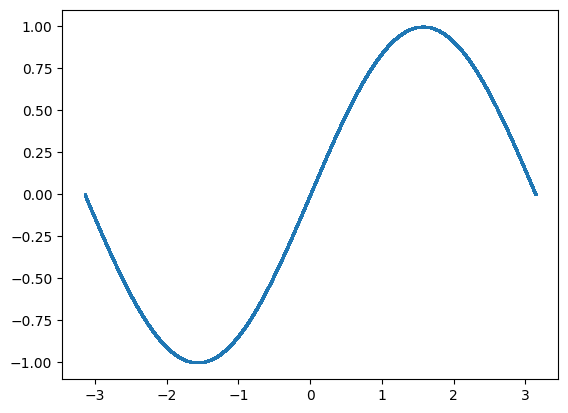

In [5]:
from matplotlib import pyplot as plt
test_data = np.random.uniform(-np.pi, np.pi, size=(2**17, 1)).astype(np.float32)
test_label = np.sin(test_data)
plt.scatter(test_data, test_label, s=1)
plt.show()

In [6]:
optimizer = nn.Adam(model.trainable_params(), learning_rate=5e-3)
loss_fn = nn.MSELoss()

In [7]:
dataset = dataset.batch(batch_size=2**5)

In [8]:
def train_loop(model, dataset, loss_fn, optimizer):
    def forwad_fn(data, label):
        logits = model(data)
        loss = loss_fn(logits, label)
        return loss, logits
    
    grad_fn = ops.value_and_grad(forwad_fn, None, optimizer.parameters, has_aux=True)
    
    @ms.jit
    def train_step(data, label):
        (loss, _), grads = grad_fn(data, label)
        loss = ops.depend(loss, optimizer(grads))
        return loss
    
    size = dataset.get_dataset_size()
    print(size)
    model.set_train()
    for batch, (data, label) in enumerate(dataset.create_tuple_iterator()):
        # print(data.shape, "  ", label.shape)
        loss = train_step(data, label)

        if batch % 100 == 0:
            loss, current = loss.asnumpy(), batch
            print(f"loss: {loss:>7f}  [{current:>3d}/{size:>3d}]")
        

In [9]:
def test_loop(model, dataset, loss_fn):
    num_batches = dataset.get_dataset_size()
    model.set_train(False)
    total, test_loss, correct = 0, 0, 0
    for data, label in dataset.create_tuple_iterator():
        pred = model(data)
        total += len(data)
        test_loss += loss_fn(pred, label).asnumpy()
        correct += (ops.isclose(pred, label, rtol=1e-2, atol=1e-8)).asnumpy().sum()
    test_loss /= num_batches
    correct /= total
    print(f"Test: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [10]:
import time
for epoch in range(10):
    print("epoch: ", epoch + 1)
    time_beg = time.time()
    train_loop(model, dataset, loss_fn, optimizer)
    time_cost = time.time()-time_beg
    print(f"Train: \n time cost: {time_cost:>4f}s\n" )
    test_loop(model, dataset, loss_fn)
    print("="*100)

epoch:  1
1024
loss: 0.510456  [  0/1024]
loss: 0.003594  [100/1024]
loss: 0.012088  [200/1024]
loss: 0.000904  [300/1024]
loss: 0.003190  [400/1024]
loss: 0.005274  [500/1024]
loss: 0.001561  [600/1024]
loss: 0.002063  [700/1024]
loss: 0.000723  [800/1024]
loss: 0.005039  [900/1024]
loss: 0.003166  [1000/1024]
Train: 
 time cost: 2.317621s

Test: 
 Accuracy: 8.8%, Avg loss: 0.001001 

epoch:  2
1024
loss: 0.001341  [  0/1024]
loss: 0.000257  [100/1024]
loss: 0.047676  [200/1024]
loss: 0.000840  [300/1024]
loss: 0.001375  [400/1024]
loss: 0.000385  [500/1024]
loss: 0.011651  [600/1024]
loss: 0.001258  [700/1024]
loss: 0.000671  [800/1024]
loss: 0.002294  [900/1024]
loss: 0.002087  [1000/1024]
Train: 
 time cost: 0.783446s

Test: 
 Accuracy: 11.1%, Avg loss: 0.000633 

epoch:  3
1024
loss: 0.000756  [  0/1024]
loss: 0.000745  [100/1024]
loss: 0.007287  [200/1024]
loss: 0.001118  [300/1024]
loss: 0.000845  [400/1024]
loss: 0.012739  [500/1024]
loss: 0.000506  [600/1024]
loss: 0.002087  [

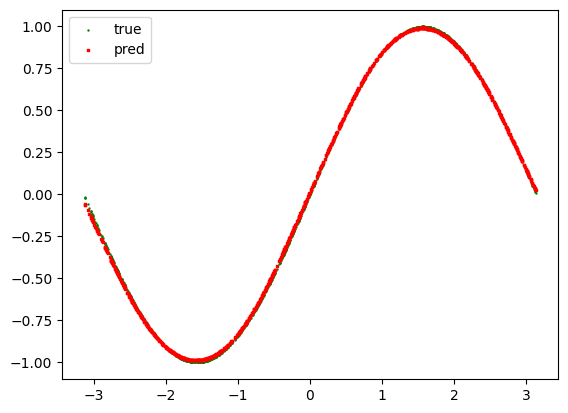

In [11]:
valid_data = np.random.uniform(-np.pi, np.pi, size=(1000, 1))
true_label = np.sin(valid_data)
pred_label = model(Tensor(valid_data, ms.float32))
plt.scatter(valid_data, true_label, color="green", s=2, marker=".")
plt.scatter(valid_data, pred_label, color="red", s=2, marker="s")
plt.legend(["true", "pred"])
plt.show()